##Natural Machine Lranslation with Attention Mechanisms

English setences to spanish

> The attention network has 10 weights by default in each weight matrix

In [142]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  4 22:31:50 2021

@author: guilhermeviveiros

Neural Machine Translation using attention mechanisms
"""

import tensorflow as tf #high-level api for deep learning operations
import os #operative system
import re #regular expressions
import numpy as np #arrays
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [143]:
def load_data(path):
    english_data,spanish_data = [],[]
    with open(path,"r") as r:
        for sequence in r:    
            sequence = re.sub(r"([?.,!¿])", r" \1", sequence)
            sequence = re.sub(r'[" "¿]+', r" ", sequence)
            sequence = re.sub(r'[\n¡]+', r"", sequence)
            splited_sequence = sequence.lower().split("\t")
            en,span = splited_sequence[0],splited_sequence[1]
            
            en = '<start> ' + en + ' <end>'
            span = '<start> ' + span + ' <end>'
            
            english_data.append(en)
            spanish_data.append(span)
    
    return english_data,spanish_data

english_data , spanish_data = load_data(path_to_file)

#if one needs to evaluate real-time predictions
def preprocess_sentence(sequence, en = True, span = False):
  
  en,span = [],[]

  sequence = re.sub(r"([?.,!¿])", r" \1", sequence)
  sequence = re.sub(r'[" "¿]+', r" ", sequence)
  sequence = re.sub(r'[\n¡]+', r"", sequence)
  splited_sequence = sequence.lower().split("\t")
  

  if(en == True and span == True):
    en,span = splited_sequence[0],splited_sequence[1]
  elif(en == True):
    en =  splited_sequence        
    en = '<start> ' + en + ' <end>'
  elif(span == True):
    span = splited_sequence
    span = '<start> ' + span + ' <end>'
            
    return en,span


def tokenize_data(data):
    #initialize the tokenizer
    tokenizer = Tokenizer(oov_token='#!?',filters='')
    
    #fit on data and transform it. Each word will be represented by an ID
    tokenizer.fit_on_texts(data)
    word_to_index = tokenizer.word_index
    tokenized_sentences = tokenizer.texts_to_sequences(data)
    
    #padd the sentences to the size of the biggest sentence
    max_sentence_size = np.max([len(i) for i in tokenized_sentences])
    padded_sentences = pad_sequences(tokenized_sentences,maxlen=max_sentence_size,dtype='int32',padding='post',truncating='post')
    
    #insert the padding token
    word_to_index['pad'] = 0 
    index_to_word = {number:key for (key,number) in word_to_index.items()}
    
    
    
    return padded_sentences,word_to_index,index_to_word,max_sentence_size, tokenizer

In [144]:
en_preprocessed_data,word_to_index_en,index_to_word_en,en_max_sentence,en_tokenizer = tokenize_data(english_data)
en_vocab_size = len(word_to_index_en) + 1
span_preprocessed_data,word_to_index_span,index_to_word_span,span_max_sentence,span_tokenizer = tokenize_data(spanish_data)
span_vocab_size = len(word_to_index_span) + 1

batch = 128
embedding_dim = 128

def numpy_to_tensors(data,labels):
    data_size = len(data)
    train_size = int (0.8 * data_size)
    
    dataset = tf.data.Dataset.from_tensor_slices((en_preprocessed_data,span_preprocessed_data))
    train_dataset = dataset.take(train_size).shuffle(train_size).batch(batch,drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = dataset.skip(train_size).batch(batch,drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    
    return train_dataset,test_dataset
    
train_dataset,test_dataset = numpy_to_tensors(en_preprocessed_data,span_preprocessed_data)

print("Size of each preprocessed english sentence = {0}".format(en_max_sentence))
print("Size of each preprocessed spanish sentence = {0}".format(span_max_sentence))

Size of each preprocessed english sentence = 51
Size of each preprocessed spanish sentence = 53


## Demonstration cell

In [145]:
for english_sentences, spanish_sentences in train_dataset.take(1):
  en = english_sentences[0]
  span = spanish_sentences[0]

  print("INPUT ---------------------------------------------------")
  print(en[0:15])
  print([index_to_word_en[i] for i in en[0:15].numpy()])

  print("LABEL ---------------------------------------------------")
  print(span[0:15])
  print([index_to_word_span[i] for i in span[0:15].numpy()])

  

INPUT ---------------------------------------------------
tf.Tensor([  2  72  73 265 129   4   3   0   0   0   0   0   0   0   0], shape=(15,), dtype=int32)
['<start>', 'no', 'one', 'knows', 'anything', '.', '<end>', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
LABEL ---------------------------------------------------
tf.Tensor([  2 116 122  69   4   3   0   0   0   0   0   0   0   0   0], shape=(15,), dtype=int32)
['<start>', 'nadie', 'sabe', 'nada', '.', '<end>', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']


In [146]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_dim,batch,**kargs):
        super(**kargs).__init__()
        self.batch = batch
        self.units = units
        self.embedding_dim = embedding_dim
        self.vocab_dim = vocab_dim
        self.embedding_layer = tf.keras.layers.Embedding(input_dim = self.vocab_dim,output_dim=embedding_dim)
        self.gru = tf.keras.layers.GRU(units=self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform'
                                      )
        
    def call(self,inputs,initial_state):
        emb = self.embedding_layer(inputs)
        #in gated recurrent units the cell state is the same as the hidden state
        gru, cell_state = self.gru(emb,initial_state = initial_state)
        return gru, cell_state

    def initialize_hidden_state(self):
      return tf.zeros(shape=(self.batch, self.units))
    
encoder = Encoder(100,embedding_dim,en_vocab_size,batch)
initial_state = encoder.initialize_hidden_state()
for a,b in train_dataset.take(1):
    print("Input shape of " + str(a.shape))
    sample_output, sample_hidden = encoder(a,initial_state)
    print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
    print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Input shape of (128, 51)
Encoder output shape: (batch size, sequence length, units) (128, 51, 100)
Encoder Hidden state shape: (batch size, units) (128, 100)


In [147]:
#calculate the score
#normalize them
#calculate the content vector
#calculate the attention vectors
class Bahdanau_attention(tf.keras.layers.Layer):
    def __init__(self, units = 128, print_shapes = True, **kargs):
        super(**kargs).__init__()
        self.units = units
        self.print_shapes = print_shapes
        #calculate the scores with Bahdanau addition formula
        #dense 1 has 1 unit to output 1 attention weight for each word
        self.dense1 = tf.keras.layers.Dense(name='dense1',units=1)
        #these three denses will be followed by a hyperbolic tangent function
        self.dense2 = tf.keras.layers.Dense(name='dense2',units=self.units,kernel_initializer = tf.keras.initializers.GlorotNormal())
        self.dense3 = tf.keras.layers.Dense(name='dense3',units=self.units,kernel_initializer = tf.keras.initializers.GlorotNormal())
        self.dense4 = tf.keras.layers.Dense(name='dense4',units=self.units,kernel_initializer = tf.keras.initializers.GlorotNormal())
       
    
    #query is the word (embedding vector) from the decoder
    #values are all outputed words (all the output vectors of the encoder) of the encoder.
    #we'll calculate attetion weights for each of this values in every query of the decoder
    #This weights are calculated and optimized with a small neural netowrk.
    #Check the paper Bahdanau attention
    def call(self,query,values,training=True):
        #query has a shape of (batch_size,values) since it corresponds to a decoder word
        #use expand dimds to add a dimension in axis= 1 -> (batch_size,1,values) to broadcast when adding the values
        query_with_time_axis = tf.expand_dims(query,axis=1)
        #calculate the score
        scores = tf.nn.tanh(tf.add(self.dense2(query_with_time_axis), self.dense3(values)))
        #linear layer to output the logit scores
        reduced_scores = self.dense1(scores)        
        #normalize them
        attention_weights = tf.nn.softmax(reduced_scores,axis=1)        
        #calculate the content vector
        context_vector = attention_weights * values
        context_vector_reduced = tf.math.reduce_sum(context_vector,axis=1)
        #calculate the attention vector
        atention_vector = tf.nn.tanh(self.dense4( tf.keras.layers.concatenate([context_vector_reduced,query])))    
        
        if(training == False):
            print("Initial values and query shape = {0}-{1}".format(values.shape,query.shape))
            print("Scores shape = " + str(scores.shape))
            print("Reduced shape shape between the query and each value = " + str(reduced_scores.shape))
            print("Attention weights shape = " + str(attention_weights.shape))
            print("Values multiplied by Attention weights  = " + str(context_vector.shape))
            print("Reduce sum of context vectir in axis 1 = " + str(context_vector_reduced.shape))
            print("Attention vector shape- Contecatenation of context vector and query = " + str(atention_vector.shape))
            print("\n")
        
        return context_vector_reduced,attention_weights
        
attention_layer = Bahdanau_attention(10,False)
attention_vector,attention_weights = attention_layer(sample_hidden,sample_output,training=False)
    
print ('Attention weights shape: (batch size, sequence length, units) {}'.format(attention_weights.shape))
print ('Attention vector shape: (batch size, units) {}'.format(attention_vector.shape))

Initial values and query shape = (128, 51, 100)-(128, 100)
Scores shape = (128, 51, 10)
Reduced shape shape between the query and each value = (128, 51, 1)
Attention weights shape = (128, 51, 1)
Values multiplied by Attention weights  = (128, 51, 100)
Reduce sum of context vectir in axis 1 = (128, 100)
Attention vector shape- Contecatenation of context vector and query = (128, 10)


Attention weights shape: (batch size, sequence length, units) (128, 51, 1)
Attention vector shape: (batch size, units) (128, 100)


In [148]:
#This Decoder layer operates for each individual decoder cell
class Decoder(tf.keras.layers.Layer):
    def __init__(self,units,embedding_dim,vocab_dim,**kargs):
        super(**kargs).__init__()
        self.units = units
        self.embedding_dim = embedding_dim
        self.vocab_dim = vocab_dim
        self.embedding_layer = tf.keras.layers.Embedding(input_dim = self.vocab_dim, output_dim=embedding_dim)
        self.fc = tf.keras.layers.Dense(vocab_dim)
        self.gru = tf.keras.layers.GRU(units=self.units,
                                       return_sequences=True, 
                                       return_state = True,
                                       recurrent_initializer='glorot_uniform'
                                      )
        
        #attention layer
        attention_layer = Bahdanau_attention(10,False)
        
    #assuming inputs for one cell
    '''
    arguments
    1) The inputs for the cell, the specific word (if in the fst cell, the word is always 'start')
    2) The previous hidden state (if in the fst cell the previous hidden state is the encoder final hidden state)
    3) The encoder outputs for each cell, to calculate the attention vector at each time step
    '''
    def call(self,inputs, hidden_state, enc_output, training = True):
    

        inputs = self.embedding_layer(inputs)
        attention_vector,attention_weights = attention_layer(hidden_state,enc_output)
        #attention_vector has shape (batch_size,hidden size)
        #inputs has a shape of (batch_size,max_lenght,embedding dim)
        
        #add the two of them
        x = tf.concat([tf.expand_dims(attention_vector,axis=1),inputs],axis=-1)
        gru_out, hidden_state = self.gru(x)
        gru_out = tf.reshape(gru_out, (-1, gru_out.shape[2]))

        #output has a shape of (batch,max_lenght,vocab_dim)
        out = self.fc(gru_out)

        if(training == False):
          print("Embedding layer shape = {0}".format(inputs.shape))
          print("Attention weights and vector shape = " + str(attention_weights.shape) + " " + str(attention_vector.shape))
          print("Added hidden state and attention vector  = " + str(x.shape))
          print("GRU hidden state shape and gru hidden cells = " + str(gru_out.shape)+ " " + str(hidden_state.shape))  
          print("\n")      
        
        return out, hidden_state, attention_weights
    
decoder = Decoder(100, embedding_dim, span_vocab_size)

sample_decoder_output, _, _ = decoder(tf.random.uniform((128, 1)),sample_hidden, sample_output, training = False)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Initial values and query shape = (128, 51, 100)-(128, 100)
Scores shape = (128, 51, 10)
Reduced shape shape between the query and each value = (128, 51, 1)
Attention weights shape = (128, 51, 1)
Values multiplied by Attention weights  = (128, 51, 100)
Reduce sum of context vectir in axis 1 = (128, 100)
Attention vector shape- Contecatenation of context vector and query = (128, 10)


Embedding layer shape = (128, 1, 128)
Attention weights and vector shape = (128, 51, 1) (128, 100)
Added hidden state and attention vector  = (128, 1, 228)
GRU hidden state shape and gru hidden cells = (128, 100) (128, 100)


Decoder output shape: (batch_size, vocab size) (128, 26165)


In [149]:
#we use masking here, so we don't panalize the model to output an <end>
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [150]:
@tf.function
def train_step(inp, targ):
  with tf.GradientTape() as tape:

    encoder_out, encoder_hidden_state = encoder(inp,initial_state)
    x = tf.expand_dims([word_to_index_en['start']]*batch,axis=1)
    decoder_hidden_state = encoder_hidden_state

    # Teacher forcing - feeding the target as the next input
    loss = 0
    for i in range(1,targ.shape[-1]):

      logit_prediction, decoder_hidden_state, _ = decoder(x,decoder_hidden_state,encoder_out)    
      loss += loss_function(targ[:,i],logit_prediction)
      #using teacher forcing, the next input is the previous output real target
      x = tf.expand_dims(targ[:,i],axis=-1)
  
  
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(gradients,variables))    


    return batch_loss

In [151]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [152]:
from tqdm import tqdm

EPOCHS = 10
import time

for epoch in tqdm(range(EPOCHS)):

  loss = 0

  for step,(X_batch,Y_batch) in enumerate(train_dataset):
    loss += train_step(X_batch,Y_batch)
    #print(loss/step)

    if(step % 100 == 0):
      print("Epoch {0} Batch {1} with loss of {2}".format(epoch+1,step+1,loss/(step+1)))

  # saving (checkpoint) the model every 2 epochs
  #checkpoint.save(file_prefix = checkpoint_prefix)

  



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Batch 1 with loss of 1.3600069284439087
Epoch 1 Batch 101 with loss of 0.9450143575668335
Epoch 1 Batch 201 with loss of 0.8606332540512085
Epoch 1 Batch 301 with loss of 0.8174349069595337
Epoch 1 Batch 401 with loss of 0.7899392247200012
Epoch 1 Batch 501 with loss of 0.7689259052276611
Epoch 1 Batch 601 with loss of 0.752898097038269
Epoch 1 Batch 701 with loss of 0.7389904260635376



 10%|█         | 1/10 [03:12<28:55, 192.82s/it]

Epoch 2 Batch 1 with loss of 0.6324355006217957
Epoch 2 Batch 101 with loss of 0.6248400211334229
Epoch 2 Batch 201 with loss of 0.6178723573684692
Epoch 2 Batch 301 with loss of 0.6114546656608582
Epoch 2 Batch 401 with loss of 0.6060491800308228
Epoch 2 Batch 501 with loss of 0.6004574298858643
Epoch 2 Batch 601 with loss of 0.5944610834121704
Epoch 2 Batch 701 with loss of 0.5884831547737122



 20%|██        | 2/10 [05:31<23:31, 176.44s/it]

Epoch 3 Batch 1 with loss of 0.5246664881706238
Epoch 3 Batch 101 with loss of 0.5235636234283447
Epoch 3 Batch 201 with loss of 0.5193876028060913
Epoch 3 Batch 301 with loss of 0.5159116387367249
Epoch 3 Batch 401 with loss of 0.5131258964538574
Epoch 3 Batch 501 with loss of 0.5093530416488647
Epoch 3 Batch 601 with loss of 0.505109429359436
Epoch 3 Batch 701 with loss of 0.5016340017318726



 30%|███       | 3/10 [07:49<19:15, 165.09s/it]

Epoch 4 Batch 1 with loss of 0.46450936794281006
Epoch 4 Batch 101 with loss of 0.4569709002971649
Epoch 4 Batch 201 with loss of 0.4557865858078003
Epoch 4 Batch 301 with loss of 0.4532727599143982
Epoch 4 Batch 401 with loss of 0.45066311955451965
Epoch 4 Batch 501 with loss of 0.44829103350639343
Epoch 4 Batch 601 with loss of 0.4460379183292389
Epoch 4 Batch 701 with loss of 0.443787544965744



 40%|████      | 4/10 [10:08<15:43, 157.27s/it]

Epoch 5 Batch 1 with loss of 0.40262043476104736
Epoch 5 Batch 101 with loss of 0.4093494713306427
Epoch 5 Batch 201 with loss of 0.4083411693572998
Epoch 5 Batch 301 with loss of 0.40578457713127136
Epoch 5 Batch 401 with loss of 0.4033348858356476
Epoch 5 Batch 501 with loss of 0.40094268321990967
Epoch 5 Batch 601 with loss of 0.3990074694156647
Epoch 5 Batch 701 with loss of 0.397674024105072



 50%|█████     | 5/10 [12:26<12:37, 151.50s/it]

Epoch 6 Batch 1 with loss of 0.3598605990409851
Epoch 6 Batch 101 with loss of 0.366990864276886
Epoch 6 Batch 201 with loss of 0.36518141627311707
Epoch 6 Batch 301 with loss of 0.3643317222595215
Epoch 6 Batch 401 with loss of 0.3633444607257843
Epoch 6 Batch 501 with loss of 0.36094552278518677
Epoch 6 Batch 601 with loss of 0.35931774973869324
Epoch 6 Batch 701 with loss of 0.3576492667198181



 60%|██████    | 6/10 [14:45<09:50, 147.55s/it]

Epoch 7 Batch 1 with loss of 0.3147839903831482
Epoch 7 Batch 101 with loss of 0.32803410291671753
Epoch 7 Batch 201 with loss of 0.3263646960258484
Epoch 7 Batch 301 with loss of 0.32593733072280884
Epoch 7 Batch 401 with loss of 0.3251701891422272
Epoch 7 Batch 501 with loss of 0.32436615228652954
Epoch 7 Batch 601 with loss of 0.3232446014881134
Epoch 7 Batch 701 with loss of 0.32198843359947205



 70%|███████   | 7/10 [17:03<07:14, 144.83s/it]

Epoch 8 Batch 1 with loss of 0.2862054705619812
Epoch 8 Batch 101 with loss of 0.29173532128334045
Epoch 8 Batch 201 with loss of 0.29274293780326843
Epoch 8 Batch 301 with loss of 0.2921733260154724
Epoch 8 Batch 401 with loss of 0.2920205593109131
Epoch 8 Batch 501 with loss of 0.2911219894886017
Epoch 8 Batch 601 with loss of 0.2899191081523895
Epoch 8 Batch 701 with loss of 0.2891673147678375



 80%|████████  | 8/10 [19:22<04:45, 142.96s/it]

Epoch 9 Batch 1 with loss of 0.25324058532714844
Epoch 9 Batch 101 with loss of 0.2601516842842102
Epoch 9 Batch 201 with loss of 0.26113781332969666
Epoch 9 Batch 301 with loss of 0.2612227499485016
Epoch 9 Batch 401 with loss of 0.2609761655330658
Epoch 9 Batch 501 with loss of 0.2606663703918457
Epoch 9 Batch 601 with loss of 0.2599762976169586
Epoch 9 Batch 701 with loss of 0.25973764061927795



 90%|█████████ | 9/10 [21:40<02:21, 141.53s/it]

Epoch 10 Batch 1 with loss of 0.22539694607257843
Epoch 10 Batch 101 with loss of 0.2364926040172577
Epoch 10 Batch 201 with loss of 0.2355004996061325
Epoch 10 Batch 301 with loss of 0.23456834256649017
Epoch 10 Batch 401 with loss of 0.23417767882347107
Epoch 10 Batch 501 with loss of 0.23390638828277588
Epoch 10 Batch 601 with loss of 0.23392881453037262
Epoch 10 Batch 701 with loss of 0.23373036086559296



100%|██████████| 10/10 [23:58<00:00, 143.88s/it]


## Evaluate function to test on test data

In [153]:
def evaluate(test_dataset):
  
  total_loss = 0
  for step,(X_batch,Y_batch) in tqdm(enumerate(test_dataset)):

    encoder_out, last_hidden_state = encoder(X_batch,initial_state)
    x = tf.expand_dims([word_to_index_en['start']]*batch,axis=1)
    decoder_in = last_hidden_state

    batch_loss = 0
    
    #for a batch we iterate over each word
    for i in range(Y_batch.shape[-1]):
      
      logit_prediction, decoder_hidden_state, _ = decoder(x,decoder_in,encoder_out)    
      decoder_in = decoder_hidden_state
      batch_loss += loss_function(Y_batch[:,i],logit_prediction)
      #using teacher forcing, the next input is the previous output real target
      x = tf.expand_dims(Y_batch[:,i],axis=-1)
    
    batch_loss = (batch_loss / int(Y_batch.shape[1]))
    total_loss += batch_loss

    if(step%30==0):
      print("Batch {0} with loss of {1}".format(step+1,batch_loss))

  total_loss = total_loss / int(step+1)
  print("Total loss of {0}".format(total_loss))

evaluate(test_dataset)


0it [00:00, ?it/s]
1it [00:00,  1.97it/s]

Batch 1 with loss of 1.1420470476150513



2it [00:00,  2.01it/s]
3it [00:01,  2.05it/s]
4it [00:01,  2.09it/s]
5it [00:02,  2.04it/s]
6it [00:02,  2.09it/s]
7it [00:03,  2.06it/s]
8it [00:03,  2.08it/s]
9it [00:04,  2.01it/s]
10it [00:04,  1.99it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.06it/s]
13it [00:06,  2.09it/s]
14it [00:06,  2.06it/s]
15it [00:07,  2.07it/s]
16it [00:07,  2.10it/s]
17it [00:08,  2.07it/s]
18it [00:08,  2.05it/s]
19it [00:09,  2.08it/s]
20it [00:09,  2.10it/s]
21it [00:10,  2.12it/s]
22it [00:10,  2.13it/s]
23it [00:11,  2.14it/s]
24it [00:11,  2.12it/s]
25it [00:12,  2.11it/s]
26it [00:12,  2.13it/s]
27it [00:12,  2.14it/s]
28it [00:13,  2.15it/s]
29it [00:13,  2.13it/s]
30it [00:14,  2.14it/s]
31it [00:14,  2.16it/s]

Batch 31 with loss of 1.079311490058899



32it [00:15,  2.11it/s]
33it [00:15,  2.13it/s]
34it [00:16,  2.09it/s]
35it [00:16,  2.10it/s]
36it [00:17,  2.11it/s]
37it [00:17,  2.12it/s]
38it [00:18,  2.09it/s]
39it [00:18,  2.11it/s]
40it [00:19,  2.13it/s]
41it [00:19,  2.13it/s]
42it [00:20,  2.14it/s]
43it [00:20,  2.06it/s]
44it [00:21,  2.03it/s]
45it [00:21,  2.06it/s]
46it [00:21,  2.10it/s]
47it [00:22,  2.12it/s]
48it [00:22,  2.14it/s]
49it [00:23,  2.12it/s]
50it [00:23,  2.09it/s]
51it [00:24,  2.08it/s]
52it [00:24,  2.08it/s]
53it [00:25,  2.02it/s]
54it [00:25,  2.00it/s]
55it [00:26,  1.99it/s]
56it [00:26,  2.02it/s]
57it [00:27,  2.03it/s]
58it [00:27,  1.98it/s]
59it [00:28,  2.02it/s]
60it [00:28,  2.04it/s]
61it [00:29,  2.00it/s]

Batch 61 with loss of 1.2679224014282227



62it [00:29,  1.95it/s]
63it [00:30,  1.98it/s]
64it [00:30,  2.01it/s]
65it [00:31,  2.05it/s]
66it [00:31,  2.08it/s]
67it [00:32,  2.09it/s]
68it [00:32,  2.09it/s]
69it [00:33,  2.11it/s]
70it [00:33,  2.06it/s]
71it [00:34,  2.02it/s]
72it [00:34,  1.97it/s]
73it [00:35,  2.02it/s]
74it [00:35,  2.05it/s]
75it [00:36,  2.05it/s]
76it [00:36,  2.07it/s]
77it [00:37,  2.09it/s]
78it [00:37,  2.02it/s]
79it [00:38,  1.97it/s]
80it [00:38,  1.94it/s]
81it [00:39,  1.96it/s]
82it [00:39,  1.94it/s]
83it [00:40,  1.97it/s]
84it [00:40,  2.02it/s]
85it [00:41,  2.06it/s]
86it [00:41,  2.07it/s]
87it [00:42,  2.07it/s]
88it [00:42,  2.02it/s]
89it [00:43,  2.06it/s]
90it [00:43,  2.08it/s]
91it [00:44,  2.08it/s]

Batch 91 with loss of 1.2928811311721802



92it [00:44,  2.11it/s]
93it [00:45,  2.11it/s]
94it [00:45,  2.12it/s]
95it [00:45,  2.10it/s]
96it [00:46,  2.08it/s]
97it [00:46,  2.07it/s]
98it [00:47,  2.09it/s]
99it [00:47,  2.11it/s]
100it [00:48,  2.09it/s]
101it [00:48,  2.05it/s]
102it [00:49,  2.06it/s]
103it [00:49,  2.10it/s]
104it [00:50,  2.04it/s]
105it [00:50,  2.01it/s]
106it [00:51,  1.99it/s]
107it [00:51,  1.96it/s]
108it [00:52,  2.00it/s]
109it [00:52,  2.04it/s]
110it [00:53,  2.06it/s]
111it [00:53,  2.10it/s]
112it [00:54,  2.04it/s]
113it [00:54,  1.99it/s]
114it [00:55,  2.05it/s]
115it [00:55,  2.08it/s]
116it [00:56,  2.05it/s]
117it [00:56,  2.06it/s]
118it [00:57,  2.08it/s]
119it [00:57,  2.04it/s]
120it [00:58,  2.02it/s]
121it [00:58,  2.03it/s]

Batch 121 with loss of 1.4184191226959229



122it [00:59,  2.06it/s]
123it [00:59,  2.09it/s]
124it [01:00,  2.09it/s]
125it [01:00,  2.02it/s]
126it [01:01,  2.02it/s]
127it [01:01,  2.07it/s]
128it [01:02,  2.10it/s]
129it [01:02,  2.12it/s]
130it [01:02,  2.13it/s]
131it [01:03,  2.14it/s]
132it [01:03,  2.12it/s]
133it [01:04,  2.05it/s]
134it [01:04,  2.02it/s]
135it [01:05,  2.07it/s]
136it [01:05,  2.10it/s]
137it [01:06,  2.11it/s]
138it [01:06,  2.09it/s]
139it [01:07,  2.09it/s]
140it [01:07,  2.11it/s]
141it [01:08,  2.10it/s]
142it [01:08,  2.11it/s]
143it [01:09,  2.07it/s]
144it [01:09,  2.01it/s]
145it [01:10,  1.98it/s]
146it [01:10,  1.95it/s]
147it [01:11,  1.96it/s]
148it [01:11,  1.94it/s]
149it [01:12,  1.98it/s]
150it [01:12,  2.01it/s]
151it [01:13,  2.03it/s]

Batch 151 with loss of 1.545925498008728



152it [01:13,  2.07it/s]
153it [01:14,  2.08it/s]
154it [01:14,  2.10it/s]
155it [01:15,  2.09it/s]
156it [01:15,  2.11it/s]
157it [01:16,  2.07it/s]
158it [01:16,  2.00it/s]
159it [01:17,  2.01it/s]
160it [01:17,  2.06it/s]
161it [01:18,  2.07it/s]
162it [01:18,  2.10it/s]
163it [01:19,  2.12it/s]
164it [01:19,  2.04it/s]
165it [01:20,  2.02it/s]
166it [01:20,  2.05it/s]
167it [01:21,  2.04it/s]
168it [01:21,  2.08it/s]
169it [01:21,  2.06it/s]
170it [01:22,  2.07it/s]
171it [01:22,  2.09it/s]
172it [01:23,  2.06it/s]
173it [01:23,  2.10it/s]
174it [01:24,  2.12it/s]
175it [01:24,  2.13it/s]
176it [01:25,  2.06it/s]
177it [01:25,  2.01it/s]
178it [01:26,  2.03it/s]
179it [01:26,  2.05it/s]
180it [01:27,  2.08it/s]
181it [01:27,  2.10it/s]

Batch 181 with loss of 2.171267032623291



182it [01:28,  2.05it/s]
183it [01:28,  2.00it/s]
184it [01:29,  2.00it/s]
185it [01:29,  2.06it/s]

Total loss of 1.3830320835113525


## Model saved in google drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

!mv training_checkpoints gdrive/MyDrive/Models/attention_model


#to retrieve the status, uncomment the next line code
#status = checkpoint.restore(tf.train.latest_checkpoint('gdrive/MyDrive/Models/attention_model'))

## Code to preprocess an english sentence, a spanish sentence or both according to the preprocess steps built in the begining

In [154]:
#if one needs to evaluate real-time predictions
def preprocess_sentence(sequence, english = True, en_tokeninzer = None, en_max_sentence = None, spanish = False, span_tokenizer = None, span_max_sentence = None):
  
  en,span = [],[]

  sequence = re.sub(r"([?.,!¿])", r" \1", sequence)
  sequence = re.sub(r'[" "¿]+', r" ", sequence)
  sequence = re.sub(r'[\n¡]+', r"", sequence)
  splited_sequence = sequence.lower().split("\t")
  
  if(english == True and spanish == True):
    en,span = splited_sequence[0],splited_sequence[1]
  elif(english == True):
    en =  splited_sequence[0]     
    en = '<start> ' + en + ' <end>'
  elif(spanish == True):
    span = splited_sequence[0]
    span = '<start> ' + span + ' <end>'

  if(len(en)!=0):
    en_tokenized = en_tokeninzer.texts_to_sequences([en])
    en = pad_sequences(en_tokenized,maxlen=en_max_sentence,dtype='int32',padding='post',truncating='post')

  if(len(span)!=0):
    span_tokenized = span_tokeninzer.texts_to_sequences([span])
    span = pad_sequences(en_tokenized,maxlen=span_max_sentence,dtype='int32',padding='post',truncating='post')
            
  return en,span

## Translate a sentence and save the attention weights

> For each word of the decoder sentence we have X attention weights according to the input length

In [194]:
def translate(sentence):
  attention_plot = np.zeros(shape=(span_max_sentence,en_max_sentence))

  en,_ = preprocess_sentence(sentence,en_tokeninzer=en_tokenizer, en_max_sentence = en_max_sentence)
  tensor = tf.expand_dims(tf.convert_to_tensor(en[0]),axis=0)
  
  initial_state = tf.zeros(shape=(1,100))
  encoder_out, encoder_hidden_state = encoder(tensor,initial_state)

  print("Encoder out shape = " + str(encoder_out.shape))
  print("encoder hidden state shape = " + str(encoder_hidden_state.shape))

  decoder_hidden_state = encoder_hidden_state

  result = ''
  lim = 0
  
  x = tf.expand_dims([word_to_index_span['<start>']],axis=1)
  print("Input shape = " + str(x.shape))

  while(lim < span_max_sentence):

    #word to feed the decoder
    logit_prediction, decoder_hidden_state, attention_weights = decoder(x,decoder_hidden_state,encoder_out)

    #save the attention weights for this word and all encoder words
    attention_plot[lim] = attention_weights.numpy().reshape(en_max_sentence,)

    #upddate the hidden state and the next word
    word_index = tf.argmax(logit_prediction,axis=1).numpy()[0]
    x = tf.expand_dims([word_index],axis=1)
    
    #append the new word to the result
    word = index_to_word_span[word_index]
    result += word + ' '

    #check if the word = end
    if(word == '<end>'):
      return result, attention_plot, lim
    
    #next word
    lim +=1
  
    
  return result, attention_plot, lim

sentence = 'its very cold here.'
result, attention_plot, lim = translate(sentence)
print("It used {0} words to translate the sentence".format(lim))
print(result)


Encoder out shape = (1, 51, 100)
encoder hidden state shape = (1, 100)
Input shape = (1, 1)
It used 5 words to translate the sentence
se volvió muy tarde . <end> 


## Plot the attention weights

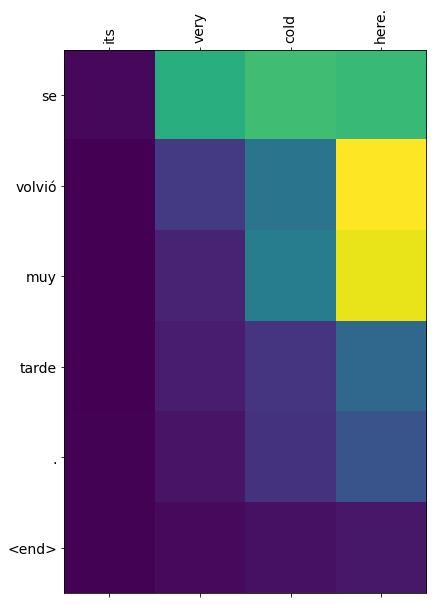

In [195]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis')
  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

attention_plot = attention_plot[:len(result.split(' '))-1, :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from “April 22, 2019” to “2019-04-22”).

In [ ]:
import tensorflow as tf
import numpy as np

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def make_dataset(num_examples):
  months = ['January','February','March','April','May','June','July','August','September','October','November','December']
  data,labels = [],[]
  for _ in range(num_examples):
    day = np.random.randint(31) + 1 
    month = np.random.randint(12)+1
    year = np.random.randint(1000,3000)

    #preprocessing
    day = day if day >= 10 else '0' + str(day)
    x = '{0} {1},{2}'.format(months[month-1],day,year)

    month = month if month >= 10 else '0' + str(month)
    y = '{0}-{1}-{2}'.format(year,month,day)

    data.append(x)
    labels.append(y)
  
  return data,labels

In [ ]:
data,labels = make_dataset(300000)

## Preprecessing step including the transformation from Numpy array to TensorFlow datasets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 1000, filters=None , lower = True, char_level=True, oov_token='#?!')

## All the data fits on RAM. Otherwise, sample some data and fit it to the tokenizer
# Labels can be None since in inference time one does not have them
def preprocess(data,labels=None):
  tokenizer.fit_on_texts(data)
  data = tokenizer.texts_to_sequences(data)
  max_size = np.max([len(i) for i in data])
  data_padded = pad_sequences(sequences=data,maxlen=np.max(max_size),padding='post',truncating='post')

  if(labels):
    labels = tokenizer.texts_to_sequences(labels)
    labels_padded = pad_sequences(sequences=labels,maxlen=np.max(max_size),padding='post',truncating='post')
  else:
    labels_padded = None
 
  return data_padded,labels_padded,tokenizer.word_index

#data,labels,index of each word, max_size the sequence can take
data,labels,word_index_dict = preprocess(data,labels)
word_index_dict['pad'] = 0
index_word_dict = { id:char for char,id in word_index_dict.items()}

In [ ]:
print(data[0])
print(list([index_word_dict[c] for c in data[0]]))
print(list([index_word_dict[c] for c in labels[0]]))

[ 9 26  7 31 27  4  3  3  5  2 16 18  8  0  0  0  0]
['a', 'p', 'r', 'i', 'l', ' ', '2', '2', ',', '1', '4', '8', '0', 'pad', 'pad', 'pad', 'pad']
['1', '4', '8', '0', '#?!', '0', '4', '#?!', '2', '2', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((data,labels))
dataset = tf.data.Dataset.from_tensor_slices((data,labels)).map(lambda x,y : (x[...,tf.newaxis],y))

train_size = 250000
batch_size = 256

train_dataset = dataset.take(train_size).shuffle(train_size).batch(batch_size = 64).prefetch(1)
test_dataset = dataset.skip(train_size).batch(batch_size = 64).prefetch(1)

## Seq2Seq model 

#### The architecture is composed by LSTM

In [ ]:
encoder = tf.keras.models.Sequential([
  tf.keras.Input(shape=(17,1)),
  tf.keras.layers.LSTM(units=128,return_sequences= False)
])

decoder = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units=128,return_sequences= True),
  tf.keras.layers.Dense(units=len(word_index_dict)+1,activation='softmax')
])

seq2seq = tf.keras.models.Sequential([
  encoder,
  tf.keras.layers.RepeatVector(max_size),
  decoder
])

seq2seq.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [ ]:
seq2seq.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = 5,
    verbose = 1
)

Epoch 1/5
3907/3907 [==============================] - 76s 14ms/step - loss: 0.7655 - acc: 0.7238 - val_loss: 0.1000 - val_acc: 0.9725
Epoch 2/5
3907/3907 [==============================] - 70s 14ms/step - loss: 0.0528 - acc: 0.9897 - val_loss: 0.0241 - val_acc: 0.9933
Epoch 3/5
3907/3907 [==============================] - 70s 14ms/step - loss: 0.0059 - acc: 0.9990 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4/5
3907/3907 [==============================] - 71s 14ms/step - loss: 0.0062 - acc: 0.9986 - val_loss: 9.5656e-04 - val_acc: 1.0000
Epoch 5/5
3907/3907 [==============================] - 70s 14ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 4.0444e-04 - val_acc: 1.0000


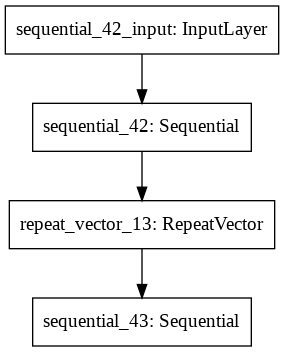

In [ ]:
tf.keras.utils.plot_model(seq2seq)

In [ ]:
predictions = seq2seq.predict(preprocess(['January 30,2020'])[0][...,np.newaxis])
print([index_word_dict[np.argmax(char)] for char in predictions[0]])

['2', '0', '2', '0', '#?!', '0', '9', '#?!', '3', '0', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']


## Seq2Seq model that receives shifted targets as decoder inputs

#### The architecture is composed by LSTM

In [ ]:
sos_value = tf.reduce_max(list(word_index_dict.values())) + 1
sos_token = 'sos'
word_index_dict[sos_token] = sos_value
index_word_dict = { id:char for char,id in word_index_dict.items()}

TypeError: ignored

In [ ]:
def shifted_target_sequences(data):
    values = tf.fill(dims=(len(data),1),value = sos_value)
    #tf.concat([sos_tokens, Y[:, :-1]], axis=1)
    #we add the first value as a <sos> token (start of sequence) and remove the last character
    l = tf.concat([values,data[:,:-1]],axis=1)

    return l

x_shifted = shifted_target_sequences(data)

#dataset = tf.data.Dataset.from_tensor_slices((data,labels))
#dataset = tf.data.Dataset.from_tensor_slices((data,labels)).map(lambda x,y : (x[...,tf.newaxis],y))

#train_size = 250000
#batch_size = 256

#train_dataset = dataset.take(train_size).shuffle(train_size).batch(batch_size = 64).prefetch(1)
#test_dataset = dataset.skip(train_size).batch(batch_size = 64).prefetch(1)

In [ ]:
input_encoder = tf.keras.Input(shape=[None],dtype=tf.int32)
input_decoder = tf.keras.Input(shape=[None],dtype=tf.int32)
input_embeddings = 100


encoder_embeddings = tf.keras.layers.Embedding(input_dim=len(word_index_dict.values()) + 1 , output_dim= input_embeddings)(input_encoder)
_, hidden_states, cell_states = tf.keras.layers.LSTM(name='encoder',units=128,return_state=True)(encoder_embeddings)
encoder_state = [hidden_states,cell_states]

decoder_embeddings = tf.keras.layers.Embedding(input_dim=len(word_index_dict.values()) + 1 , output_dim= input_embeddings)(input_decoder)
decoder = tf.keras.layers.LSTM(name='decoder',units = 128,return_sequences = True)(inputs = decoder_embeddings, initial_state = encoder_state)

out = tf.keras.layers.Dense(units = len(word_index_dict.values()) + 1 , activation= 'softmax')(decoder)
model = tf.keras.models.Model(inputs=[input_encoder,input_decoder], outputs = [out])

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [ ]:
data.shape,x_shifted.shape

((300000, 17), TensorShape([300000, 17]))

In [ ]:
model.fit(
    [data,x_shifted],
    labels,
    batch_size = 64,
    epochs = 2,
    verbose = 1
)

Epoch 1/2
4688/4688 [==============================] - 49s 10ms/step - loss: 0.4809 - acc: 0.8418
Epoch 2/2
4688/4688 [==============================] - 45s 10ms/step - loss: 0.0014 - acc: 0.9998


Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, None, 100)    3700        input_69[0][0]                   
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, None, 100)    3700        input_70[0][0]                   
___________________________________________________________________________________________

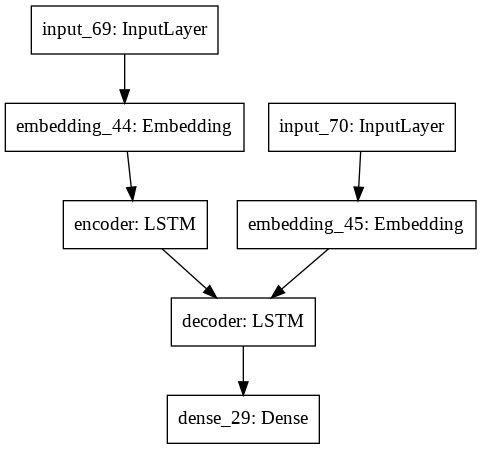

In [ ]:
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
predictions = model.predict([data[0:2],shifted_target_sequences(data[0:2])])
print([index_word_dict[np.argmax(char)] for char in data[0]])
print([index_word_dict[np.argmax(char)] for char in predictions[0]])

['pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
['1', '4', '8', '0', '#?!', '0', '4', '#?!', '2', '2', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
